<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Preprocessing" data-toc-modified-id="1.-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Preprocessing</a></span></li><li><span><a href="#2.-Model-Fitting" data-toc-modified-id="2.-Model-Fitting-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Model Fitting</a></span><ul class="toc-item"><li><span><a href="#2.1-Description-of-Methodology" data-toc-modified-id="2.1-Description-of-Methodology-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>2.1 Description of Methodology</a></span></li><li><span><a href="#2.2-Reasonable-Assumptions" data-toc-modified-id="2.2-Reasonable-Assumptions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2.2 Reasonable Assumptions</a></span></li><li><span><a href="#2.3-Data-Splitting" data-toc-modified-id="2.3-Data-Splitting-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>2.3 Data Splitting</a></span></li><li><span><a href="#2.3-Model-Selection" data-toc-modified-id="2.3-Model-Selection-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>2.3 Model Selection</a></span></li><li><span><a href="#2.3-Residual-Analysis" data-toc-modified-id="2.3-Residual-Analysis-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>2.3 Residual Analysis</a></span></li><li><span><a href="#Sensibility-Checks" data-toc-modified-id="Sensibility-Checks-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Sensibility Checks</a></span></li></ul></li></ul></div>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

import statsmodels.api as sm

Read in the demographics and social welfare dataframes from Part 1. In addition, the two dataframes are concatenated to create the **model_df dataframe**.

In [3]:
dem_df = pd.read_csv("demographics.csv")
swdf = pd.read_csv("unemployed_swdf.csv")
model_df = pd.concat([dem_df, swdf], axis=1)
model_df.head()

,age,gender,race,highest_grade,tertiary_edu,province_current,province_moved,province_before,province_during,job_in_apr,work_in_apr,src_income_before_apr,lost_income_in_apr,total_income_in_apr,uif_in_apr,grant_from_gov_ques,grant_from_gov
0,39.0,Man,White,Grade 9,No,Gauteng,No,NaN,NaN,No,No,Income from a business,No,3532.0,No,Yes,Disability Grant
1,72.0,Woman,Asian/Indian,Grade 0,NaN,KwaZulu-Natal,No,NaN,NaN,No,No,Government grants,Yes,1500.0,No,Yes,Child Support Grant (CSG)
2,30.0,Woman,African/Black,Grade 10,Yes,Gauteng,No,NaN,NaN,No,No,Government grants,Yes,4200.0,Yes,Yes,Child Support Grant (CSG)
3,48.0,Woman,African/Black,Grade 10,No,Gauteng,No,NaN,NaN,No,No,Income from employment,No,3532.0,No,Yes,Child Support Grant (CSG)
4,49.0,Woman,African/Black,Grade 9,No,Gauteng,No,NaN,NaN,No,No,Government grants,No,4200.0,Yes,Yes,Old Age Pension Grant (OAP)


## 1. Preprocessing

In this section, the data is processed into a more appropriate form for training and testing. String values in the dataframe are converted to their corresponding categorical value and columns are converted to their appropriate data type.

The **province_current**, **province_moved**, **province_before** and **province_during** columns are dropped as they are not relevant for the model that will be built in this section. Since the dataframe only stores information of unemployed individuals, **job_in_Apr** and **work_in_apr** only store the response "No". Therefore, these columns are also dropped because they are redundant. 

In [4]:
model_df = model_df.drop(["province_current", "province_moved", "province_before", "province_during", "job_in_apr", "work_in_apr"], axis=1)
model_df.head()

,age,gender,race,highest_grade,tertiary_edu,src_income_before_apr,lost_income_in_apr,total_income_in_apr,uif_in_apr,grant_from_gov_ques,grant_from_gov
0,39.0,Man,White,Grade 9,No,Income from a business,No,3532.0,No,Yes,Disability Grant
1,72.0,Woman,Asian/Indian,Grade 0,NaN,Government grants,Yes,1500.0,No,Yes,Child Support Grant (CSG)
2,30.0,Woman,African/Black,Grade 10,Yes,Government grants,Yes,4200.0,Yes,Yes,Child Support Grant (CSG)
3,48.0,Woman,African/Black,Grade 10,No,Income from employment,No,3532.0,No,Yes,Child Support Grant (CSG)
4,49.0,Woman,African/Black,Grade 9,No,Government grants,No,4200.0,Yes,Yes,Old Age Pension Grant (OAP)


The following functions will be used to assign numerical values to all of the relevant categorical values in the **model_df** dataframe.

In [5]:
def check_gender(gender):
    if gender == "Woman": return 1
    else: return 0

def check_matric(highest_grade):
    if highest_grade == "Grade 12": return 1
    else: return 0

def check_tertedu(tertiary_edu):
    if tertiary_edu == "Yes" : return 1 
    else: return 0 
    
def check_race(race):
    if race == "African/Black": return 0
    elif race == "Coloured": return 1
    elif race == "White": return 2
    else: return 4
    
def check_grant_type(grant_from_gov):
    if grant_from_gov == "Child Support Grant (CSG)": return 0
    elif grant_from_gov == "Old Age Pension Grant (OAP)": return 1
    elif grant_from_gov == "Disability Grant": return 2
    elif grant_from_gov == "R350 COVID-19 Social Relief of Distress Grant": return 3
    elif grant_from_gov == "Foster Child Grant": return 4
    elif grant_from_gov == "Social relief or distress grant": return 5
    elif grant_from_gov == "Care Dependency Grant": return 6
    else: return 7
    

def check_income_source(source_income):
    if source_income == "Government grants": return 0
    elif source_income == "Income from employment": return 1
    elif source_income == "Household had no income in February": return 2
    elif source_income == "Income from a business": return 3
    elif source_income == "Money from friends or family": return 4
    else: return 5

Assign numerical values to all of the relevant categorical values in the **model_df** dataframe. In addition, the **highest_grade** column is renamed to **matric** and stores a binary value indicating whether or not the participant completed Grade 12.

In [6]:
# Convert all "Yes" or "No" answers in the entire dataframe.
model_df = model_df.replace("No", 0)
model_df = model_df.replace("Yes", 1)

# Assign numerical values to all of the relevant categorical values in the model_df dataframe.
model_df["gender"] = np.vectorize(check_gender)(model_df["gender"])
model_df["race"] = np.vectorize(check_race)(model_df["race"])
model_df["highest_grade"] = np.vectorize(check_matric)(model_df["highest_grade"])
model_df["src_income_before_apr"] = np.vectorize(check_income_source)(model_df["src_income_before_apr"])
model_df["grant_from_gov"] = np.vectorize(check_grant_type)(model_df["grant_from_gov"])

# Change highest grade to matric
model_df.rename(columns = {'highest_grade':'matric'}, inplace = True)

# Drop all NaN values in the dataframe
model_df = model_df.dropna()

model_df.head()

,age,gender,race,matric,tertiary_edu,src_income_before_apr,lost_income_in_apr,total_income_in_apr,uif_in_apr,grant_from_gov_ques,grant_from_gov
0,39.0,0,2,0,0.0,3,0.0,3532.0,0.0,1.0,2
2,30.0,1,0,0,1.0,0,1.0,4200.0,1.0,1.0,0
3,48.0,1,0,0,0.0,1,0.0,3532.0,0.0,1.0,0
4,49.0,1,0,0,0.0,0,0.0,4200.0,1.0,1.0,1
5,34.0,0,0,0,0.0,4,1.0,1800.0,1.0,1.0,2


Convert all columns to their appropriate data type. 

In [7]:
model_df.age = model_df.age.astype('float64')
model_df.gender = model_df.gender.astype('category')
model_df.race = model_df.race.astype('category')
model_df.matric_grade = model_df.matric.astype('category')
model_df.tertiary_edu = model_df.tertiary_edu.astype('category')
model_df.src_income_before_apr = model_df.src_income_before_apr.astype('category')
model_df.lost_income_in_apr = model_df.lost_income_in_apr.astype('category')
model_df.total_income_in_apr = model_df.total_income_in_apr.astype('float64')
model_df.uif_in_apr = model_df.uif_in_apr.astype('category')
model_df.grant_from_gov_ques = model_df.grant_from_gov_ques.astype('category')
model_df.grant_from_gov = model_df.grant_from_gov.astype('category')
print(model_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695 entries, 0 to 934
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    695 non-null    float64 
 1   gender                 695 non-null    category
 2   race                   695 non-null    category
 3   matric                 695 non-null    int64   
 4   tertiary_edu           695 non-null    category
 5   src_income_before_apr  695 non-null    category
 6   lost_income_in_apr     695 non-null    category
 7   total_income_in_apr    695 non-null    float64 
 8   uif_in_apr             695 non-null    category
 9   grant_from_gov_ques    695 non-null    category
 10  grant_from_gov         695 non-null    category
dtypes: category(8), float64(2), int64(1)
memory usage: 28.4 KB
None


<ipython-input-7-33be8a67745b>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model_df.matric_grade = model_df.matric.astype('category')


## 2. Model Fitting

**Question: Given that a participant was unemployed, how likely were they to receive the UIF reduced work-time benefit from the government during April 2020?**

The model in this section aims to determine if an unemployed participant received the UIF reduced work time benefit from the government during April 2020.

### 2.1 Description of Methodology

To generate the model, we first drop the **uif_in_apr** column from the **model_df** dataframe and set that as the target variable y. The remaining columns in the dataframe are used as the explanatory variables X. We then split the dataframe into a training and testing set. The training set will be used to generate and improve an initial model, and the testing set will be used to evaluate the final model. The training data makes up 80% of the dataframe and the testing data makes up 20%. From here, we generate an initial model of the form: 
<br><br>
$$y = \beta_0 + \beta_1age + \beta_2gender + \beta_3race + \beta_4matric + \beta_5tertiary\_edu + \beta_6src\_income\_before\_apr + \beta_7lost\_income\_in\_apr + \beta_8total\_income\_in\_apr + \beta_9grant\_from\_gov\_ques + \beta_{10}grant\_from\_gov $$.
<br>
After generating this model, we explore the p-values of all of its variables and only keep the variables with a p-value less than 0.05.

### 2.2 Reasonable Assumptions

We assume that the **gender** and the **grant_from_gov** variables will be the most significant (ie: the ones with the lowest p-values). This is because women were the group most likely to lose their jobs in April 2020 (as stipulated in the Labour Section). We also assume that if a participant was already receiving another type of grant from the government, then they were most likely also receiving the UIF reduced work-time benefit during April 2020.  

### 2.3 Data Splitting

The training data makes up 80% of the dataframe and the testing data makes up 20%.

In [8]:
# Split the data into the explanatory varaibles X and the target variable y 
y = model_df["uif_in_apr"]
X = model_df.drop("uif_in_apr", axis=1)

# Split the data into an 80% training set and a 20% testing split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=101)

In [9]:
X_train

,age,gender,race,matric,tertiary_edu,src_income_before_apr,lost_income_in_apr,total_income_in_apr,grant_from_gov_ques,grant_from_gov
727,30.0,0,0,1,1.0,0,1.0,3532.0,1.0,0
112,37.0,0,0,1,0.0,0,0.0,16000.0,1.0,1
140,55.0,1,0,1,0.0,0,0.0,200.0,1.0,2
573,33.0,1,0,1,1.0,1,0.0,3200.0,1.0,7
275,34.0,0,0,1,0.0,0,1.0,2200.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
103,35.0,0,0,1,0.0,2,0.0,3532.0,1.0,1
798,43.0,1,0,0,0.0,0,0.0,1380.0,1.0,7
764,44.0,1,0,1,0.0,0,0.0,3532.0,1.0,1
456,29.0,1,0,0,0.0,0,0.0,1700.0,1.0,1


### 2.3 Model Selection

We are using the variables in the **model_df** dataframe to determine whether or not someone was likely to receive the UIF reduced work-time benefit from the government during April 2020. Essentially, we are modelling a categorical response variable (**uif_in_apr**) with only two response categories ("Yes" and "No"). Thus, we will be constructing a Binary Logistic Regression. The initial model we construct has the following form: 

$$y = \beta_0 + \beta_1age + \beta_2gender + \beta_3race + \beta_4matric + \beta_5tertiary\_edu + \beta_6src\_income\_before\_apr + \beta_7lost\_income\_in\_apr + \beta_8total\_income\_in\_apr + \beta_9grant\_from\_gov\_ques + \beta_{10}grant\_from\_gov $$

Where $y$ represents the logarithm of the odds that a respondent will receive the UIF reduced work-time benefit from the government during April 2020.

Constructing this initial model using the training data yields:

In [47]:
log_reg = sm.Logit(y_train, X_train[["age", "gender", "race","matric", "tertiary_edu", "src_income_before_apr", "lost_income_in_apr", "total_income_in_apr", "grant_from_gov_ques", "grant_from_gov"]]).fit(disp=0)
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             uif_in_apr   No. Observations:                  556
Model:                          Logit   Df Residuals:                      546
Method:                           MLE   Df Model:                            9
Date:                Sun, 20 Jun 2021   Pseudo R-squ.:                 0.05681
Time:                        12:16:55   Log-Likelihood:                -322.08
converged:                       True   LL-Null:                       -341.48
Covariance Type:            nonrobust   LLR p-value:                 1.251e-05
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
age                       0.0235      0.011      2.076      0.038       0.001       0.046
gender                    0.4783      0.196      2.442      0.015       0.094       0.862
race                     -0.3101      0.362     -0.856      0.392      -1.020       0.400
matric                    0.0444      0.211      0.211      0.833      -0.369       0.458
tertiary_edu             -0.1476      0.218     -0.677      0.498      -0.575       0.279
src_income_before_apr    -0.1179      0.090     -1.316      0.188      -0.293       0.058
lost_income_in_apr       -0.6413      0.194     -3.307      0.001      -1.021      -0.261
total_income_in_apr   -4.741e-05   3.49e-05     -1.357      0.175      -0.000    2.11e-05
grant_from_gov_ques      -0.0665      0.492     -0.135      0.893      -1.031       0.898
grant_from_gov            0.1745      0.056      3.139      0.002       0.066       0.283
=========================================================================================
"""

Inspecting the results of this initial implementation we observe that the **age**, **gender**, **lost_income_in_apr** and **grant_from_gov** variables have p-values less than 0.05. This indicates that these four variables are statistically more signifacant than the other variables in the initial model. We select a subset of features and construct a reduced model as: 

$$y = \beta_0 +  \beta_1age + \beta_2gender  + \beta_3lost\_income\_in\_apr + \beta_4grant\_from\_gov$$

The reduced model yields the following results: 

In [52]:
log_reg = sm.Logit(y_train, X_train[["age", "gender", "lost_income_in_apr","grant_from_gov"]]).fit(disp=0)
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             uif_in_apr   No. Observations:                  556
Model:                          Logit   Df Residuals:                      552
Method:                           MLE   Df Model:                            3
Date:                Sun, 20 Jun 2021   Pseudo R-squ.:                 0.04941
Time:                        15:25:17   Log-Likelihood:                -324.61
converged:                       True   LL-Null:                       -341.48
Covariance Type:            nonrobust   LLR p-value:                 2.243e-07
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
age                    0.0166      0.004      3.805      0.000       0.008       0.025
gender                 0.4773      0.192      2.482      0.013       0.100       0.854
lost_income_in_apr    -0.6737      0.189     -3.569      0.000      -1.044      -0.304
grant_from_gov         0.1441      0.053      2.734      0.006       0.041       0.247
======================================================================================
"""

Since the p-values of the reduced model are all less than 0.05, we will select this model to make and test hypotheses.

### 2.3 Residual Analysis

Before evaluating it on the test set, let us analyze the residuals of this model to ensure there are no major issues evident.

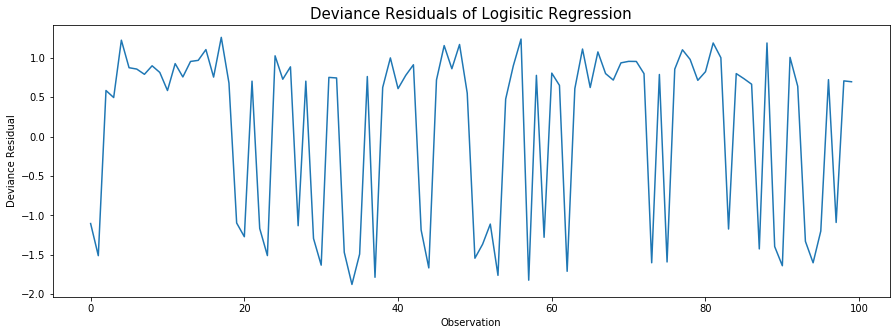

In [54]:
plt.figure(figsize=(15,5))
plots = log_reg.resid_dev[:100]
plt.plot(range(100), plots.values)
plt.title("Deviance Residuals of Logisitic Regression", fontsize=15)
plt.ylabel("Deviance Residual")
plt.xlabel("Observation")
plt.show()

Observing that there are no apparent patterns in the residual plot allows us to conclude that there are no major issues with the fitted model. We can now evaluate the model using the test data.

### Sensibility Checks

Our initial assumptions were partially correct. We believed that **gender** and **grant_from_gov** were significant variables to determine whether or not a participant received the UIF reduced work-time benefit in April 2020. The other two significant variables are **lost_income_in_apr** and **age**.

**age** and **gender** and **grant_from_gov** are all positive coefficients. This implies older an individuals that are women, and that received any other kind of grant from the government during April 2020 would hav most likely received the UIF reduced work-time benefit from the government during April 2020. In addition, the **lost_income_in_apr** has a negative coefficient, and this implies those that lost income were less likely to receive the UIF reduced work-time benefit in Apr 2020. 